In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import os
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

**Data preprocessing**<br>
loading dataset

In [3]:
train_dir = './train'
test_dir = './test'
img_size = 48 

data augmentation

In [4]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   rescale=1./255,
                                   validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
traingen = train_datagen.flow_from_directory(train_dir,
                                       shuffle = True,
                                       target_size = (img_size, img_size),
                                       color_mode = "grayscale",
                                       class_mode = 'categorical',
                                       subset='training')

valgen = validation_datagen.flow_from_directory(test_dir, 
                                     shuffle = False, 
                                     target_size = (img_size, img_size),
                                     color_mode = "grayscale",
                                     class_mode = 'categorical',
                                     subset='validation')

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


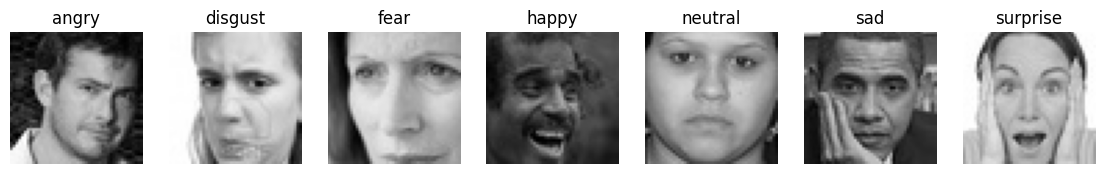

In [8]:
plt.figure(figsize=(14,22))
i = 1
#show 7 categories of emotion
for expression in os.listdir(train_dir):
    if expression == '.DS_Store':
        continue
    img = load_img(train_dir + '/' + expression + '/' + (os.listdir(train_dir + '/'+expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

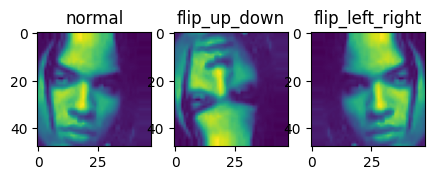

In [9]:
plt.figure(figsize=(5, 5))
a = traingen[0][0][1]
plt.subplot(1, 3, 1)
plt.title('normal')
plt.imshow(a)
plt.subplot(1, 3, 2)
plt.title('flip_up_down')
plt.imshow(tf.image.flip_up_down(a))
plt.subplot(1, 3, 3)
plt.title('flip_left_right')
plt.imshow(tf.image.flip_left_right(a))

**Modeling**

In [8]:
inputs = tf.keras.Input(shape=(48, 48, 1))
model = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
model = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.3)(model)

model = Conv2D(128, (5,5), padding='same', activation='relu')(model)
model = BatchNormalization()(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.25)(model)

model = Conv2D(256, (3, 3), padding='same', activation='relu')(model)
model = BatchNormalization()(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.4)(model)

b = model

model = keras.layers.GlobalAveragePooling2D()(model)
model = keras.layers.Reshape((1, 1, 256))(model)
model = keras.layers.Dense(units=256 // 4, activation='relu', use_bias=False)(model)
model = keras.layers.Dense(units=256, activation='sigmoid', use_bias=False)(model)

model = keras.layers.Multiply()([b, model])
model = keras.layers.Activation("relu")(model)

model = Flatten()(model)
model = Dense(256,activation = 'relu')(model)
model = BatchNormalization()(model)
model = Dropout(0.25)(model)

model = Dense(512,activation = 'relu')(model)
model = BatchNormalization()(model)
model = Dropout(0.25)(model)

outputs = Dense(7, activation='softmax')(model)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

/Users/yangtiancheng/miniforge3/envs/tf2_8/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 64)  256         ['conv2d_1[0][0]']               
 alization)                                                                                   

**Training**

In [11]:
history = model.fit(traingen, epochs = 40, validation_data = valgen)

Epoch 1/40
 74/718 [==>...........................] - ETA: 38s - loss: 0.8439 - accuracy: 0.6643

KeyboardInterrupt: 

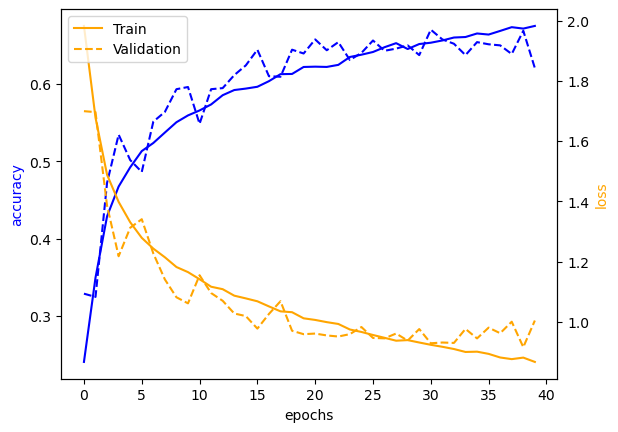

In [12]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], color='blue')
ax1.plot(history.history['val_accuracy'], color='blue', linestyle='dashed')
ax2.plot(history.history['loss'], color='orange')
ax2.plot(history.history['val_loss'], color='orange', linestyle='dashed')
ax1.set_xlabel('epochs')
ax2.set_ylabel('loss', color='orange')
ax1.set_ylabel('accuracy', color='b')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
#save the entire model
model.save('emo_class.h5')

In [13]:
train_loss, train_accu = model.evaluate(traingen)
test_loss, test_accu = model.evaluate(valgen)

45/45 [==============================] - 1s 21ms/step - loss: 0.9099 - accuracy: 0.6620


In [1]:
#randomly pick an angry img to validate our model
angry_path = '/Users/yangtiancheng/Desktop/final_project/test/angry/PrivateTest_10131363.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
plt.imshow(angry_img)
img = np.expand_dims(angry_img,axis = 0) # makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
print(result)
img_index = result.index(max(result))
print(label_dict[img_index])


NameError: name 'load_img' is not defined

**Saliency Map**

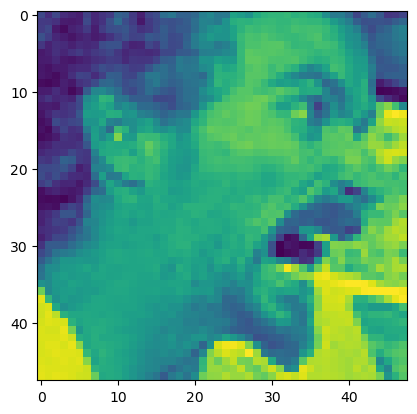

In [56]:
#random select img
angry_path = '/Users/yangtiancheng/Desktop/final_project/test/angry/PrivateTest_10304478.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
plt.imshow(angry_img)
angry_img = img_to_array(angry_img)

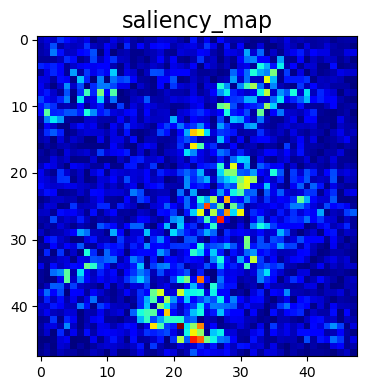

In [58]:
#saliency map demo
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore(0)

from keras import backend as K
from tf_keras_vis.saliency import Saliency
from keras.applications.vgg16 import preprocess_input

angry_path = '/Users/yangtiancheng/Desktop/final_project/test/angry/PrivateTest_10304478.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
angry_img = img_to_array(angry_img)

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)
#x = preprocess_input(img)
saliency_map = saliency(score, angry_img)
saliency_map = saliency_map.reshape(48,48)

f, ax = plt.subplots(figsize=(12, 4))
ax.set_title('saliency_map', fontsize=16)
ax.imshow(saliency_map, cmap='jet')

plt.tight_layout()
plt.show()

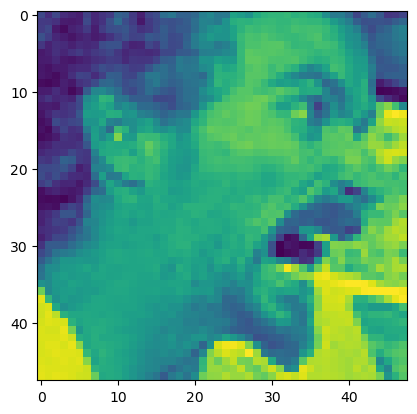

In [59]:
angry_path = '/Users/yangtiancheng/Desktop/final_project/test/angry/PrivateTest_10304478.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
plt.imshow(angry_img)
angry_img = img_to_array(angry_img)
from tf_keras_vis.gradcam import Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)
cam = gradcam(score,
              angry_img,
              penultimate_layer=-1)

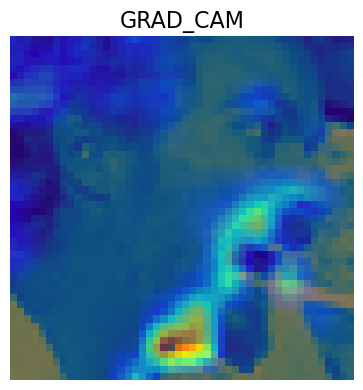

In [61]:
angry_path = '/Users/yangtiancheng/Desktop/final_project/test/angry/PrivateTest_10304478.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
#grad_cam demo
f, ax = plt.subplots( figsize=(12, 4))
heatmap = np.uint8(plt.cm.jet(cam[0])[..., :3] * 255)
heatmap = heatmap.reshape(48,48,3)

ax.set_title('GRAD_CAM', fontsize=16)
ax.imshow(angry_img)

ax.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax.axis('off')
plt.tight_layout()
plt.show()

In [62]:
#take a look at the classification report
validation_steps_per_epoch = np.math.ceil(valgen.samples / valgen.batch_size)
predictions = model.predict_generator(valgen, steps=validation_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 
true_classes = valgen.classes
class_labels = list(valgen.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

/var/folders/mb/3tmdh4wx517b0jgh48bqs83w0000gn/T/ipykernel_2878/2469112129.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valgen, steps=validation_steps_per_epoch)
2023-02-12 17:36:34.222823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

       angry       0.58      0.60      0.59       191
     disgust       0.86      0.27      0.41        22
        fear       0.56      0.22      0.31       204
       happy       0.89      0.84      0.86       354
     neutral       0.49      0.81      0.61       246
         sad       0.49      0.51      0.50       249
    surprise       0.77      0.70      0.73       166

    accuracy                           0.63      1432
   macro avg       0.66      0.56      0.57      1432
weighted avg       0.65      0.63      0.62      1432



**Apply this model to the real time camera capture**

In [ ]:
import cv2

import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

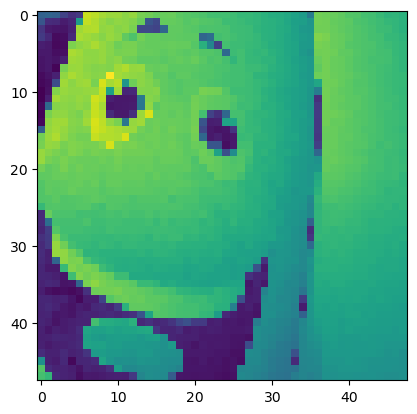

In [63]:
# see if it can identify the facial expression on my banana
path = './download.jpg'
img = load_img(path,target_size = (48,48),color_mode = "grayscale")
plt.imshow(img)

In [64]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)
img_index = result.index(max(result))
print(label_dict[img_index])

1/1 [==============================] - 0s 90ms/step
[0.0, 0.0, 0.0, 1.0, 7.992245e-14, 0.0, 0.0]
Happy


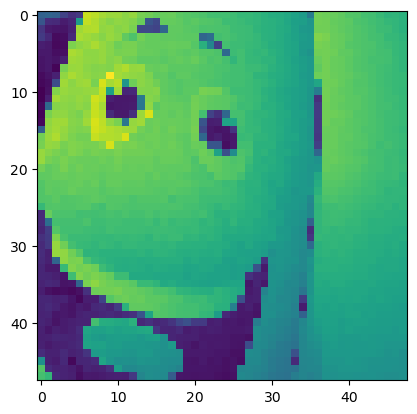

In [65]:
angry_path = './download.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
plt.imshow(angry_img)
angry_img = img_to_array(angry_img)
from tf_keras_vis.gradcam import Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)
cam = gradcam(score,
              angry_img,
              penultimate_layer=-1)

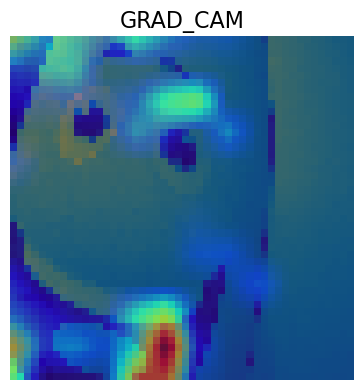

In [67]:
angry_path = './download.jpg'
angry_img = load_img(angry_path,target_size = (48,48),color_mode = "grayscale")
#grad_cam demo
f, ax = plt.subplots( figsize=(12, 4))
heatmap = np.uint8(plt.cm.jet(cam[0])[..., :3] * 255)
heatmap = heatmap.reshape(48,48,3)

ax.set_title('GRAD_CAM', fontsize=16)
ax.imshow(angry_img)

ax.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax.axis('off')
plt.tight_layout()
plt.show()
